In [1]:
import os

os.environ['SPS_HOME'] = '/export/home/aschaibl/fsps'

In [2]:
import jax
jax.clear_caches()

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"  # Only GPU 0 will be visible to JAX.
import jax

# Verify the available devices
print("Available devices:", jax.devices())

Available devices: [CudaDevice(id=0)]


E0221 13:34:21.946902 3011250 cuda_dnn.cc:534] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
E0221 13:34:21.946937 3011250 cuda_dnn.cc:538] Memory usage: 41853255680 bytes free, 42298834944 bytes total.
E0221 13:34:21.947105 3011250 cuda_dnn.cc:534] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
E0221 13:34:21.947122 3011250 cuda_dnn.cc:538] Memory usage: 41853255680 bytes free, 42298834944 bytes total.


# RUBIX pipeline

RUBIX is designed as a linear pipeline, where the individual functions are called and constructed as a pipeline. This allows as to execude the whole data transformation from a cosmological hydrodynamical simulation of a galaxy to an IFU cube in two lines of code. This notebook shows, how to execute the pipeline. To see, how the pipeline is execuded in small individual steps per individual function, we refer to the notebook `rubix_pipeline_stepwise.ipynb`.

## How to use the Pipeline
1) Define a `config`
2) Setup the `pipeline yaml`
3) Run the RUBIX pipeline
4) Do science with the mock-data

## Step 1: Config

The `config` contains all the information needed to run the pipeline. Those are run specfic configurations. Currently we just support Illustris as simulation, but extensions to other simulations (e.g. NIHAO) are planned.

For the `config` you can choose the following options:
- `pipeline`: you specify the name of the pipeline that is stored in the yaml file in rubix/config/pipeline_config.yml
- `logger`: RUBIX has implemented a logger to report the user, what is happening during the pipeline execution and give warnings
- `data - args - particle_type`: load only stars particle ("particle_type": ["stars"]) or only gas particle ("particle_type": ["gas"]) or both ("particle_type": ["stars","gas"])
- `data - args - simulation`: choose the Illustris simulation (e.g. "simulation": "TNG50-1")
- `data - args - snapshot`: which time step of the simulation (99 for present day)
- `data - args - save_data_path`: set the path to save the downloaded Illustris data
- `data - load_galaxy_args - id`: define, which Illustris galaxy is downloaded
- `data - load_galaxy_args - reuse`: if True, if in th esave_data_path directory a file for this galaxy id already exists, the downloading is skipped and the preexisting file is used
- `data - subset`: only a defined number of stars/gas particles is used and stored for the pipeline. This may be helpful for quick testing
- `simulation - name`: currently only IllustrisTNG is supported
- `simulation - args - path`: where the data is stored and how the file will be named
- `output_path`: where the hdf5 file is stored, which is then the input to the RUBIX pipeline
- `telescope - name`: define the telescope instrument that is observing the simulation. Some telescopes are predefined, e.g. MUSE. If your instrument does not exist predefined, you can easily define your instrument in rubix/telescope/telescopes.yaml
- `telescope - psf`: define the point spread function that is applied to the mock data
- `telescope - lsf`: define the line spread function that is applied to the mock data
- `telescope - noise`: define the noise that is applied to the mock data
- `cosmology`: specify the cosmology you want to use, standard for RUBIX is "PLANCK15"
- `galaxy - dist_z`: specify at which redshift the mock-galaxy is observed
- `galaxy - rotation`: specify the orientation of the galaxy. You can set the types edge-on or face-on or specify the angles alpha, beta and gamma as rotations around x-, y- and z-axis
- `ssp - template`: specify the simple stellar population lookup template to get the stellar spectrum for each stars particle. In RUBIX frequently "BruzualCharlot2003" is used.

In [4]:
#NBVAL_SKIP
import matplotlib.pyplot as plt
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        },
        
        "subset": {
            "use_subset": True,
            "subset_size": 1000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",
    "output_modified": False,

    "telescope":
        {"name": "MUSE",
         "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
         "lsf": {"sigma": 0.5},
         "noise": {"signal_to_noise": 1,"noise_distribution": "normal"},},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1,
         "rotation": {"type": "edge-on"},
        },
        
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },        
}

2025-02-21 13:34:23,643 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|


2025-02-21 13:34:23,644 - rubix - INFO - Rubix version: 0.0.post238+gf560922
E0221 13:34:23.692806 3011250 cuda_dnn.cc:534] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
E0221 13:34:23.953431 3011250 cuda_dnn.cc:538] Memory usage: 41853255680 bytes free, 42298834944 bytes total.
E0221 13:34:23.954272 3011250 cuda_dnn.cc:534] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
E0221 13:34:23.954327 3011250 cuda_dnn.cc:538] Memory usage: 41853255680 bytes free, 42298834944 bytes total.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

## Step 2: Pipeline yaml

To run the RUBIX pipeline, you need a yaml file (stored in `rubix/config/pipeline_config.yml`) that defines which functions are used during the execution of the pipeline. This shows the example pipeline yaml to compute a stellar IFU cube.

```yaml
calc_ifu:
  Transformers:
    rotate_galaxy:
      name: rotate_galaxy
      depends_on: null
      args: []
      kwargs:
        type: "face-on"
    filter_particles:
      name: filter_particles
      depends_on: rotate_galaxy
      args: []
      kwargs: {}
    spaxel_assignment:
      name: spaxel_assignment
      depends_on: filter_particles
      args: []
      kwargs: {}

    reshape_data:
      name: reshape_data
      depends_on: spaxel_assignment
      args: []
      kwargs: {}

    calculate_spectra:
      name: calculate_spectra
      depends_on: reshape_data
      args: []
      kwargs: {}

    scale_spectrum_by_mass:
      name: scale_spectrum_by_mass
      depends_on: calculate_spectra
      args: []
      kwargs: {}
    doppler_shift_and_resampling:
      name: doppler_shift_and_resampling
      depends_on: scale_spectrum_by_mass
      args: []
      kwargs: {}
    calculate_datacube:
      name: calculate_datacube
      depends_on: doppler_shift_and_resampling
      args: []
      kwargs: {}
    convolve_psf:
      name: convolve_psf
      depends_on: calculate_datacube
      args: []
      kwargs: {}
    convolve_lsf:
      name: convolve_lsf
      depends_on: convolve_psf
      args: []
      kwargs: {}
    apply_noise:
      name: apply_noise
      depends_on: convolve_lsf
      args: []
      kwargs: {}
```

Ther is one thing you have to know about the naming of the functions in this yaml: To use the functions inside the pipeline, the functions have to be called exactly the same as they are returned from the core module function!

## Step 3: Run the pipeline

After defining the `config` and the `pipeline_config` you can simply run the whole pipeline by these two lines of code.

In [ ]:
#NBVAL_SKIP
pipe = RubixPipeline(config)

rubixdata = pipe.run()

/export/home/aschaibl/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /export/home/aschaibl/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-02-21 13:08:51,248 - rubix - INFO - Getting rubix data...
2025-02-21 13:08:51,250 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2025-02-21 13:08:51,585 - rubix - INFO - Centering stars particles
2025-02-21 13:08:52,589 - rubix - WARNING - The Subset value is set in config. Using only subset of size 1000 for stars
2025-02-21 13:08:52,594 - rubix - INFO - Data loaded with 1000 star particles and 0 gas particles.
2025-02-21 13:08:52,595 - rubix - INFO - Data loaded with 56 properties.
2025-02-21 13:08:52,595 - rubix - DEBUG - Data: RubixData(galaxy=Galaxy(redshift=2.220446049250313e-16, center=array([10410.08408094, 35160.6188816 , 30040.60047238]), halfmassrad_stars=8.711988190754308), stars=StarsData(coords=Array([[ -8.358398  ,   0.34375   ,  10.205078  ],


## Step 4: Mock-data

Now we have our final datacube and can use the mock-data to do science. Here we have a quick look in the optical wavelengthrange of the mock-datacube and show the spectra of a central spaxel and a spatial image.

In [ ]:
#NBVAL_SKIP
import jax.numpy as jnp

wave = pipe.telescope.wave_seq
# get the indices of the visible wavelengths of 4000-8000 Angstroms
visible_indices = jnp.where((wave >= 4000) & (wave <= 8000))


This is how you can access the spectrum of an individual spaxel, the wavelength can be accessed via `pipe.wave_seq`

(25, 25, 3721)


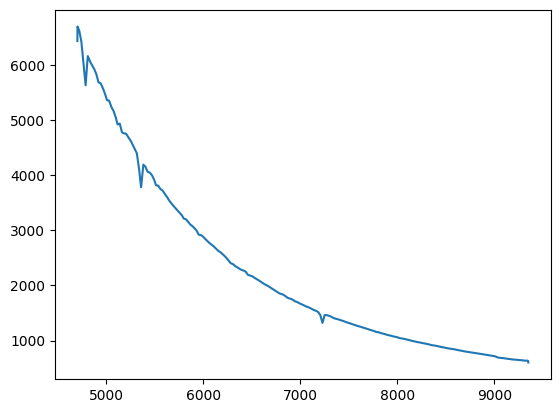

In [ ]:
#NBVAL_SKIP
wave = pipe.telescope.wave_seq

spectra = rubixdata.stars.datacube # Spectra of all stars
print(spectra.shape)

plt.plot(wave, spectra[12,12,:])


Plot a spacial image of the data cube

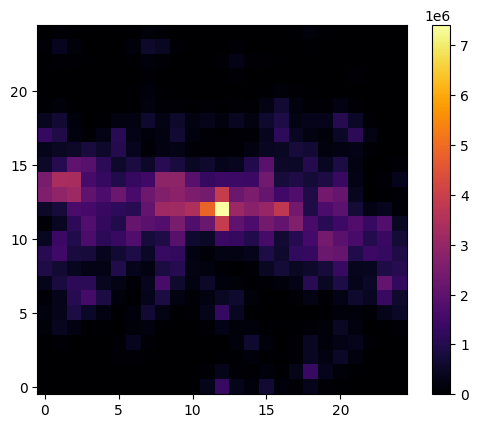

In [ ]:
#NBVAL_SKIP
# get the spectra of the visible wavelengths from the ifu cube
visible_spectra = rubixdata.stars.datacube[:, :, visible_indices[0]]
#visible_spectra.shape

# Sum up all spectra to create an image
image = jnp.sum(visible_spectra, axis = 2)
plt.imshow(image, origin="lower", cmap="inferno")
plt.colorbar()

## DONE!

Congratulations, you have sucessfully run the RUBIX pipeline to create your own mock-observed IFU datacube! Now enjoy playing around with the RUBIX pipeline and enjoy doing amazing science with RUBIX :)